# Donwload the data

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
import kaggle
import tensorflow as tf
import pandas as pd

In [ ]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Preprocessing of Data, Tokenization and Numericalization:

In [ ]:
import pandas as pd

In [ ]:
dataset = pd.read_csv('/content/IMDB Dataset.csv')

In [ ]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 60000
sequence_length = 200

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
#text_ds = dataset.map(lambda x, y: x)
vectorize_layer.adapt(dataset.review)

In [ ]:
len(vectorize_layer.get_vocabulary())

60000

In [ ]:
input_data = ["This is an example sentence"]
transformed_data = vectorize_layer(input_data)
print(transformed_data)

tf.Tensor(
[[  11    7   33  462 3813    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  

In [ ]:
embedding_layer = tf.keras.layers.Embedding(60000, 16)

In [ ]:
embedding_layer(transformed_data).shape

TensorShape([1, 200, 16])

In [ ]:
Labels = []
for i in range(len(dataset.sentiment)):
  if dataset.sentiment[i] == "positive":
    Labels.append(1)
  else:
    Labels.append(0)

In [ ]:
df = pd.DataFrame({'Column1': dataset.sentiment, 'Column2': Labels})

In [ ]:
df.head()

,Column1,Column2
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


In [ ]:
Inputs = vectorize_layer(dataset.review)

In [ ]:
Labels = df.Column2

In [ ]:
# Create a TensorFlow dataset from the vectorized data
Inputs = tf.data.Dataset.from_tensor_slices(Inputs)
Labels = tf.data.Dataset.from_tensor_slices(Labels)

In [ ]:
dataset = tf.data.Dataset.zip((Inputs, Labels))
dataset

<_ZipDataset element_spec=(TensorSpec(shape=(200,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
#Training and Validation data split :
dataset = dataset.shuffle(len(dataset))
train_size = int(0.8 * len(dataset))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
batch_size = 128

# Batch the dataset
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [ ]:
len(train_dataset)

313

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# **Bert Fine-Tuning**

# Bert Preprocessing

In [ ]:
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 47.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

We can choose one of these models to fine-tune
;In our case we will choose the small Bert

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.9928099  -0.18611872  0.36673853  0.1523371   0.65504426
  0.9681154  -0.94862705  0.00216182 -0.9877732   0.06842728 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946307  0.34321266  0.33231518 ...  0.21300897  0.71020764
  -0.05771176]
 [-0.2874206   0.3198098  -0.23018597 ...  0.5845501  -0.21329726
   0.72692066]
 [-0.6615712   0.68876785 -0.8743292  ...  0.10877268 -0.2617322
   0.4785534 ]
 ...
 [-0.22561154 -0.28925663 -0.07064398 ...  0.47566003  0.8327717
   0.40025344]
 [-0.29824272 -0.27473173 -0.05450511 ...  0.48849759  1.0955356
   0.18163322]
 [-0.44378266  0.00930682  0.07223728 ...  0.17290092  1.1833241
   0.07898061]]


In [ ]:
import pandas as pd
dataset = pd.read_csv('/content/IMDB Dataset.csv')

In [ ]:
Labels = []
for i in range(len(dataset.sentiment)):
  if dataset.sentiment[i] == "positive":
    Labels.append(1)
  else:
    Labels.append(0)

In [ ]:
Inputs = []
for text in dataset.review:
  Inputs.append([text])

In [ ]:
import numpy as np

In [ ]:
Inputs = np.array(Inputs)
Labels = np.array(Labels)

In [ ]:
Inputs.shape

(50000, 1)

In [ ]:
Labels.shape

(50000,)

In [ ]:
Labels = Labels.reshape(-1,1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(Inputs, Labels, test_size=0.2, random_state=42,shuffle = True)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Convert the numpy arrays back to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_dataset=train_dataset.batch(200)
val_dataset=val_dataset.batch(200)

# Apply caching and prefetching
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Build the model and training

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.5)(net)
  net = tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.01), name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
Model = build_classifier_model()
bert_raw_result = Model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.19532844]], shape=(1, 1), dtype=float32)


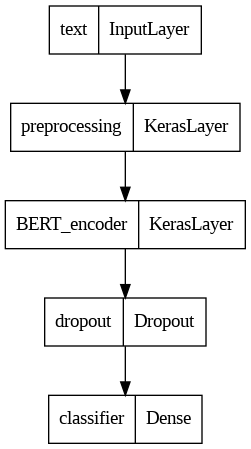

In [ ]:
tf.keras.utils.plot_model(Model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [ ]:
#Learning rate scheduler:
def LR_scheduler(epoch):
    lr = 5e-5
    lr = lr*(1-0.1)**(epoch)
    return lr

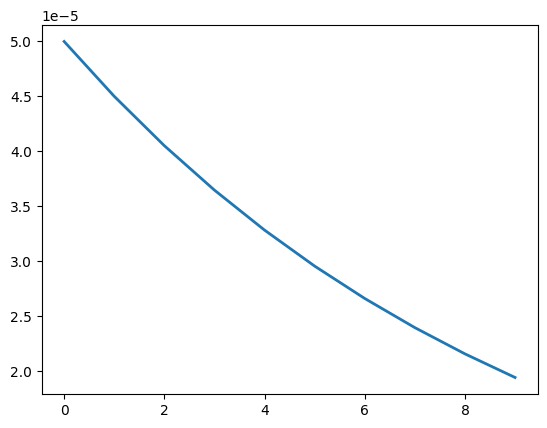

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = []
y = []
for epoch in range(10):
  y.append(LR_scheduler(epoch))
  x.append(epoch)

fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)


plt.show()

In [ ]:
Model.compile(optimizer=tf.keras.optimizers.AdamW(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(LR_scheduler)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.string, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [ ]:
Model.fit(train_dataset,epochs=10,callbacks=[callback],validation_data=val_dataset)

Epoch 1/10
200/200 [==============================] - 604s 3s/step - loss: 0.4919 - accuracy: 0.7729 - val_loss: 0.3621 - val_accuracy: 0.8473 - lr: 5.0000e-05
Epoch 2/10
200/200 [==============================] - 600s 3s/step - loss: 0.3468 - accuracy: 0.8574 - val_loss: 0.3490 - val_accuracy: 0.8592 - lr: 4.5000e-05
Epoch 3/10
200/200 [==============================] - 584s 3s/step - loss: 0.2878 - accuracy: 0.8866 - val_loss: 0.3724 - val_accuracy: 0.8646 - lr: 4.0500e-05
Epoch 4/10
200/200 [==============================] - 633s 3s/step - loss: 0.2337 - accuracy: 0.9148 - val_loss: 0.3892 - val_accuracy: 0.8682 - lr: 3.6450e-05
Epoch 5/10
200/200 [==============================] - 584s 3s/step - loss: 0.1839 - accuracy: 0.9354 - val_loss: 0.4445 - val_accuracy: 0.8716 - lr: 3.2805e-05
Epoch 6/10
200/200 [==============================] - 585s 3s/step - loss: 0.1511 - accuracy: 0.9483 - val_loss: 0.4966 - val_accuracy: 0.8641 - lr: 2.9525e-05
Epoch 7/10
200/200 [====================

We can see that the best generalized result is an accuracy of 86% and we recommand stoping the training at the third epoch.

This bert model suffers form the overfitting compared to RNN-LSTM, and this can be solved by fine tnining the hyperparameters and also trying the original BERT model.

# Validation

In [ ]:
Model.evaluate(val_dataset)

In [ ]:
predictions = Model.predict(val_dataset)

In [ ]:
predictions = np.round(predictions).astype(int).flatten().tolist()

print(predictions)

In [ ]:
Real_predictions = []

for _, outputs in val_dataset:
    Real_predictions.extend(outputs.numpy().tolist())

print(Real_predictions)

In [ ]:
j = 0
n = 0
for i in range(len(predictions)):
  if predictions[i] == Real_predictions[i]:
    j = j + 1
  else:
    n = n + 1


print("There are: ", j ," True predictions")
print("There are: ", n ," False predictions")
print("Accuracy = ",j/(j+n),"%")